In [1]:
import gdown
import pims
import torch as tr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from vre import VRE
from vre.representations import build_representations_from_cfg
from vre.utils import get_project_root, image_read

%load_ext autoreload
%autoreload 2

In [2]:
def dwd_video_if_needed() -> str:
    """download the video in the resources dir if not exist and return the path"""
    video_path = get_project_root() / "resources/testVideo.mp4"
    if not video_path.exists():
        video_path.parent.mkdir(exist_ok=True, parents=True)
        gdown.download("https://drive.google.com/uc?id=158U-W-Gal6eXxYtS1ca1DAAxHvknqwAk", f"{video_path}")
    return f"{video_path}"
video = pims.Video(dwd_video_if_needed())
print(video)

<Frames>
Format: H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10
Source: /home/mihai/code/video-representations-extractor/resources/testVideo.mp4
Duration: 301.001 seconds
Frame rate: 29.970 fps
Length: 9021 frames
Frame Shape: (720, 1280, 3)



In [3]:
device = "cuda" if tr.cuda.is_available() else "cpu"
all_representations_dict: dict[str, dict] = {
    "rgb": {"type": "default", "name": "rgb", "dependencies": [], "parameters": {}, "vre_parameters": {}},
    "opticalflow raft": {"type": "optical-flow", "name": "raft", "dependencies": [],
                         "parameters": {"inference_height": 360, "inference_width": 640,
                                        "small": False, "mixed_precision": False, "iters": 20},
                         "vre_parameters": {"device": device}},
    "depth odoflow (raft)": {"type": "depth", "name": "odo-flow", "dependencies": ["opticalflow raft"],
                             "parameters": {"linear_ang_vel_correction": True, "focus_correction": True,
                                            "cosine_correction_scipy": False, "cosine_correction_gd": True,
                                            "sensor_fov": 75, "sensor_width": 3840, "sensor_height": 2160,
                                            "min_depth_meters": 0, "max_depth_meters": 400},
                             "vre_parameters": {"velocities_path": "DJI_0956_velocities.npz"}},
}

representations = build_representations_from_cfg(all_representations_dict)
print(representations)

[20240506 14:29:19-VRE-INFO] Building 'optical-flow'/'opticalflow raft' (__init__.py:build_representation_from_cfg:83)
[20240506 14:29:19-VRE-INFO] Building 'default'/'rgb' (__init__.py:build_representation_from_cfg:83)
[20240506 14:29:19-VRE-INFO] Building 'depth'/'depth odoflow (raft)' (__init__.py:build_representation_from_cfg:83)


{'opticalflow raft': [VRE Representation] FlowRaft(opticalflow raft), 'rgb': [VRE Representation] RGB(rgb), 'depth odoflow (raft)': [VRE Representation] DepthOdoFlow(depth odoflow (raft))}


In [4]:
vre = VRE(video, representations, output_dir=Path.cwd() / "here")
print(vre)
start_frame = np.random.randint(0, len(video) - 5)
end_frame = start_frame + 5
reprs_setup = {k: v["vre_parameters"] for k, v in all_representations_dict.items() if k in vre.representations}
vre.run(start_frame, end_frame, batch_size=1, reprs_setup=reprs_setup, output_dir_exist_mode="skip_computed")

VRE (3 representations). Video: '/home/mihai/code/video-representations-extractor/resources/testVideo.mp4' (shape: (9021, 720, 1280, 3))


[20240506 14:29:25-VRE-INFO] 
  - Video path: '/home/mihai/code/video-representations-extractor/resources/testVideo.mp4'
  - Output dir: '/home/mihai/code/video-representations-extractor/examples/notebooks/here' (exist mode: 'skip_computed')
  - Representations (3): opticalflow raft, rgb, depth odoflow (raft)
  - Video shape: (9021, 720, 1280, 3) (FPS: 29.97002997002997)
  - Output frames (5): [6732 : 6736]
  - Batch size: 1
  - Export npy: True
  - Export png: True
  - Exception mode: 'stop_execution'
 (vre_runtime_args.py:_print_call:69)
[20240506 14:29:25-VRE-INFO] Loading weights from '/home/mihai/code/video-representations-extractor/weights/raft/raft-things.pkl' (flow_raft.py:vre_setup:51)
[VRE] rgb bs=1: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]
[20240506 14:30:06-VRE-INFO] Loading velocities from '/home/mihai/code/video-representations-extractor/weights/DJI_0956_velocities.npz' (depth_odo_flow.py:vre_setup:47)
[VRE] depth odoflow (raft) bs=1: 100%|██████████| 5/5 [00:13<00:0

,opticalflow raft,rgb,depth odoflow (raft)
6732,26.199124,0.923512,2.711287
6733,2.473211,0.955560,2.700021
6734,2.465633,0.971671,2.613119
6735,2.369971,0.938172,2.656838
6736,2.423704,0.924657,2.620820


## Plot some frame

3


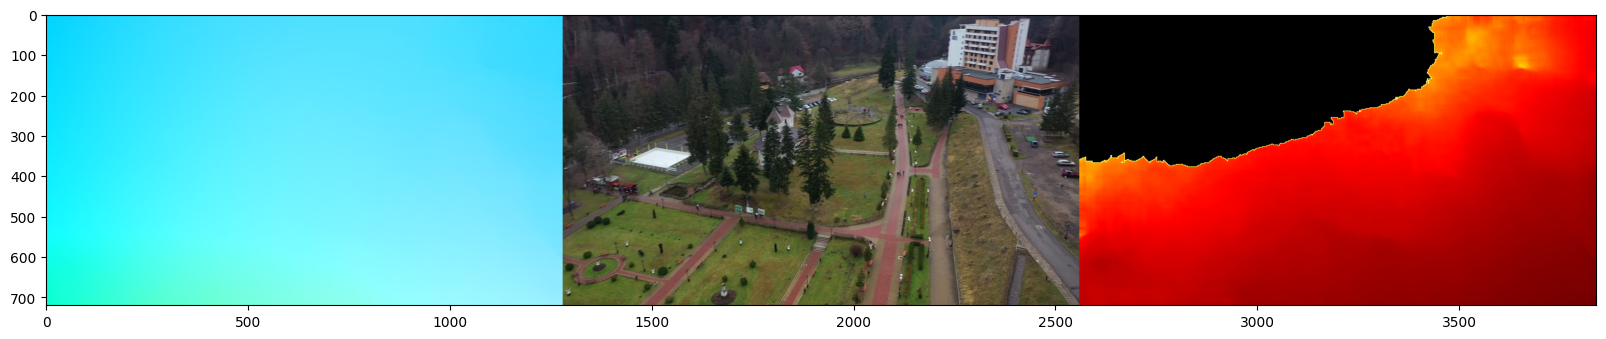

In [7]:
imgs = [image_read(vre.output_dir / r / "png" / f"{start_frame}.png") for r in vre.representations]
print(len(imgs))
imgs = np.concatenate(imgs, axis=1)
plt.figure(figsize=(20, 10))
plt.imshow(imgs)